In [ ]:
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import timeit

# Just Python functions

In [ ]:
def rastrigin(x, n=2):
    # Calculate the value of Rastrigin function at a given point in space
    return 10 * n + tf.reduce_sum(tf.pow(x, 2) - 10 * tf.math.cos(2.0 * math.pi * x), axis=1, keepdims=True)


def get_initial_solution(k, n=2):
    # Return random solutions
    return tf.random.uniform([k, n], minval=-5.12, maxval=5.12, dtype=tf.float32)


def get_energies(k):
    # Return initial energies of agents
    return tf.zeros([k, 1], dtype=tf.float32) + 5.0


def do_reproduction(reproduce_solution, reproduce_energy, n):
    # Reproduction arena
    arena_r = 2 * (tf.reduce_sum(tf.ones_like(reproduce_solution[:, 0], dtype=tf.int32)) // 2)

    a = tf.reshape(reproduce_solution[:arena_r], [-1, 2, n])[:, 0, :]
    b = tf.reshape(reproduce_solution[:arena_r], [-1, 2, n])[:, 1, :]

    reposition = tf.random.uniform([tf.reduce_sum(tf.ones_like(a[:, 0], dtype=tf.int32)), n], minval=-1, maxval=1)
    reposition = reposition / tf.norm(reposition, axis=1, keepdims=True)

    new_position = ((a + b) / 2.0) + (tf.maximum((tf.norm(a - b, axis=1, keepdims=True) / 2.0), 1e-3) * reposition)
    new_position = tf.clip_by_value(new_position, clip_value_min=-5.12, clip_value_max=5.12)

    new_solution = tf.concat([
            reproduce_solution[:arena_r],
            new_position,
            reproduce_solution[arena_r:]],
        axis=0)
    new_energy = tf.concat([
            reproduce_energy[:arena_r] - 2.5,
            5.0 * tf.ones_like(new_position[:, :1], dtype=tf.float32),
            reproduce_energy[arena_r:]],
        axis=0)

    return new_solution, new_energy


def do_fight(fight_solution, fight_energy, n):
    # Fighting arena
    arena_f = 2 * (tf.reduce_sum(tf.ones_like(fight_solution[:, 0], dtype=tf.int32)) // 2)
    score = rastrigin(fight_solution, n)
    best_score = tf.reduce_min(score)

    a = tf.reshape(score[:arena_f], [-1, 2, 1])[:, 0, :]
    b = tf.reshape(score[:arena_f], [-1, 2, 1])[:, 1, :]
    
    winner = tf.concat([a < b, a >= b], axis=1)
    prize = tf.reduce_sum(
        tf.minimum(tf.where(winner, 0.0, tf.reshape(fight_energy[:arena_f], [-1, 2])), 2.0),
        axis=1, keepdims=True)
    prize = tf.where(winner, prize, -1.0 * prize)
    prize = tf.reshape(prize, [-1, 1])

    new_energy = tf.concat([fight_energy[:arena_f] + prize, fight_energy[arena_f:]], axis=0)
    not_dead = new_energy[:, 0] > 1e-5
    new_energy = tf.boolean_mask(new_energy, not_dead)
    new_solution = tf.boolean_mask(fight_solution, not_dead)

    return new_solution, new_energy, best_score

In [ ]:
def emas_rastrigin_no_opt(k, epochs, n):
    k = tf.constant(k, dtype=tf.int32)
    n_ = tf.constant(n, dtype=tf.int32)
    epochs = tf.constant(epochs, dtype=tf.int32)

    best_scores = tf.zeros([epochs], dtype=tf.float32) + math.nan
    pop_size = tf.zeros([epochs], dtype=tf.int32)

    energy = get_energies(k)
    solution = get_initial_solution(k, n_)

    step = tf.constant(0, dtype=tf.int32)
    while tf.less(step, epochs):
        tf.autograph.experimental.set_loop_options(
            shape_invariants=[(solution, tf.TensorShape([None, n])), (energy, tf.TensorShape([None, 1]))]
        )
        reproduce = (energy > 10)[:, 0]
        fight = tf.math.logical_not(reproduce)

        reproduce_solution, reproduce_energy = do_reproduction(
            tf.boolean_mask(solution, reproduce),
            tf.boolean_mask(energy, reproduce),
            n_)
        fight_solution, fight_energy, best_score = do_fight(
            tf.boolean_mask(solution, fight),
            tf.boolean_mask(energy, fight),
            n)

        solution = tf.concat([reproduce_solution, fight_solution], axis=0)
        energy = tf.concat([reproduce_energy, fight_energy], axis=0)

        perm = tf.random.shuffle(tf.cumsum(tf.ones_like(energy[:, 0], dtype=tf.int32)) - 1)
        solution = tf.gather(solution, perm)
        energy = tf.gather(energy, perm)

        best_scores = tf.tensor_scatter_nd_update(
            best_scores, [[step]], [best_score])
        pop_size = tf.tensor_scatter_nd_update(
            pop_size, [[step]], [tf.reduce_sum(tf.ones_like(energy, dtype=tf.int32))])

        step += 1
    
    return solution, energy, best_scores, pop_size

In [ ]:
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    emas_rastrigin_no_opt(k=100, epochs=1000, n=10)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 20.3378s


# Utility functions decorated with tf.function

In [ ]:
@tf.function()
def rastrigin(x, n=2):
    # Calculate the value of Rastrigin function at a given point in space
    return 10 * n + tf.reduce_sum(tf.pow(x, 2) - 10 * tf.math.cos(2.0 * math.pi * x), axis=1, keepdims=True)


@tf.function()
def get_initial_solution(k, n=2):
    # Return random solutions
    return tf.random.uniform([k, n], minval=-5.12, maxval=5.12, dtype=tf.float32)


@tf.function()
def get_energies(k):
    # Return initial energies of agents
    return tf.zeros([k, 1], dtype=tf.float32) + 5.0


@tf.function()
def do_reproduction(reproduce_solution, reproduce_energy, n):
    # Reproduction arena
    arena_r = 2 * (tf.reduce_sum(tf.ones_like(reproduce_solution[:, 0], dtype=tf.int32)) // 2)

    a = tf.reshape(reproduce_solution[:arena_r], [-1, 2, n])[:, 0, :]
    b = tf.reshape(reproduce_solution[:arena_r], [-1, 2, n])[:, 1, :]

    reposition = tf.random.uniform([tf.reduce_sum(tf.ones_like(a[:, 0], dtype=tf.int32)), n], minval=-1, maxval=1)
    reposition = reposition / tf.norm(reposition, axis=1, keepdims=True)

    new_position = ((a + b) / 2.0) + (tf.maximum((tf.norm(a - b, axis=1, keepdims=True) / 2.0), 1e-3) * reposition)
    new_position = tf.clip_by_value(new_position, clip_value_min=-5.12, clip_value_max=5.12)

    new_solution = tf.concat([
            reproduce_solution[:arena_r],
            new_position,
            reproduce_solution[arena_r:]],
        axis=0)
    new_energy = tf.concat([
            reproduce_energy[:arena_r] - 2.5,
            5.0 * tf.ones_like(new_position[:, :1], dtype=tf.float32),
            reproduce_energy[arena_r:]],
        axis=0)

    return new_solution, new_energy


@tf.function()
def do_fight(fight_solution, fight_energy, n):
    # Fighting arena
    arena_f = 2 * (tf.reduce_sum(tf.ones_like(fight_solution[:, 0], dtype=tf.int32)) // 2)
    score = rastrigin(fight_solution, n)
    best_score = tf.reduce_min(score)

    a = tf.reshape(score[:arena_f], [-1, 2, 1])[:, 0, :]
    b = tf.reshape(score[:arena_f], [-1, 2, 1])[:, 1, :]
    
    winner = tf.concat([a < b, a >= b], axis=1)
    prize = tf.reduce_sum(
        tf.minimum(tf.where(winner, 0.0, tf.reshape(fight_energy[:arena_f], [-1, 2])), 2.0),
        axis=1, keepdims=True)
    prize = tf.where(winner, prize, -1.0 * prize)
    prize = tf.reshape(prize, [-1, 1])

    new_energy = tf.concat([fight_energy[:arena_f] + prize, fight_energy[arena_f:]], axis=0)
    not_dead = new_energy[:, 0] > 1e-5
    new_energy = tf.boolean_mask(new_energy, not_dead)
    new_solution = tf.boolean_mask(fight_solution, not_dead)

    return new_solution, new_energy, best_score

In [ ]:
def emas_rastrigin_some_opt(k, epochs, n):
    k = tf.constant(k, dtype=tf.int32)
    n_ = tf.constant(n, dtype=tf.int32)
    epochs = tf.constant(epochs, dtype=tf.int32)

    best_scores = tf.zeros([epochs], dtype=tf.float32) + math.nan
    pop_size = tf.zeros([epochs], dtype=tf.int32)

    energy = get_energies(k)
    solution = get_initial_solution(k, n_)

    step = tf.constant(0, dtype=tf.int32)
    while tf.less(step, epochs):
        tf.autograph.experimental.set_loop_options(
            shape_invariants=[(solution, tf.TensorShape([None, n])), (energy, tf.TensorShape([None, 1]))]
        )
        reproduce = (energy > 10)[:, 0]
        fight = tf.math.logical_not(reproduce)

        reproduce_solution, reproduce_energy = do_reproduction(
            tf.boolean_mask(solution, reproduce),
            tf.boolean_mask(energy, reproduce),
            n_)
        fight_solution, fight_energy, best_score = do_fight(
            tf.boolean_mask(solution, fight),
            tf.boolean_mask(energy, fight),
            n)

        solution = tf.concat([reproduce_solution, fight_solution], axis=0)
        energy = tf.concat([reproduce_energy, fight_energy], axis=0)

        perm = tf.random.shuffle(tf.cumsum(tf.ones_like(energy[:, 0], dtype=tf.int32)) - 1)
        solution = tf.gather(solution, perm)
        energy = tf.gather(energy, perm)

        best_scores = tf.tensor_scatter_nd_update(
            best_scores, [[step]], [best_score])
        pop_size = tf.tensor_scatter_nd_update(
            pop_size, [[step]], [tf.reduce_sum(tf.ones_like(energy, dtype=tf.int32))])

        step += 1
    
    return solution, energy, best_scores, pop_size

In [ ]:
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    emas_rastrigin_some_opt(k=100, epochs=1000, n=10)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 15.6573s


# Fully decorated (no XLA)

XLA pre-compilation is not available here due to variable length of some tensors.

In [ ]:
@tf.function(reduce_retracing=True)
def emas_rastrigin(k, epochs, n):
    with tf.GradientTape() as t:
        with t.stop_recording():
            k = tf.constant(k, dtype=tf.int32)
            n_ = tf.constant(n, dtype=tf.int32)
            epochs = tf.constant(epochs, dtype=tf.int32)

            best_scores = tf.zeros([epochs], dtype=tf.float32) + math.nan
            pop_size = tf.zeros([epochs], dtype=tf.int32)

            energy = get_energies(k)
            solution = get_initial_solution(k, n_)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                tf.autograph.experimental.set_loop_options(
                    shape_invariants=[(solution, tf.TensorShape([None, n])), (energy, tf.TensorShape([None, 1]))]
                )
                reproduce = (energy > 10)[:, 0]
                fight = tf.math.logical_not(reproduce)

                reproduce_solution, reproduce_energy = do_reproduction(
                    tf.boolean_mask(solution, reproduce),
                    tf.boolean_mask(energy, reproduce),
                    n_)
                fight_solution, fight_energy, best_score = do_fight(
                    tf.boolean_mask(solution, fight),
                    tf.boolean_mask(energy, fight),
                    n)

                solution = tf.concat([reproduce_solution, fight_solution], axis=0)
                energy = tf.concat([reproduce_energy, fight_energy], axis=0)

                perm = tf.random.shuffle(tf.cumsum(tf.ones_like(energy[:, 0], dtype=tf.int32)) - 1)
                solution = tf.gather(solution, perm)
                energy = tf.gather(energy, perm)

                best_scores = tf.tensor_scatter_nd_update(
                    best_scores, [[step]], [best_score])
                pop_size = tf.tensor_scatter_nd_update(
                    pop_size, [[step]], [tf.reduce_sum(tf.ones_like(energy, dtype=tf.int32))])

                step += 1
            
            return solution, energy, best_scores, pop_size

In [ ]:
# Warm-up just to trigger function tracing
solution, energy, best_scores, pop_size = emas_rastrigin(k=100, epochs=10, n=10)

start_time = timeit.default_timer()

with tf.device('cpu:0'):
    emas_rastrigin(k=100, epochs=1000, n=10)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 0.2664s


In [ ]:
# Warm-up just to trigger function tracing
solution, energy, best_scores, pop_size = emas_rastrigin(k=100, epochs=10, n=10)

start_time = timeit.default_timer()

with tf.device('gpu:0'):
    emas_rastrigin(k=100, epochs=1000, n=10)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 1.6891s


# Check the results

In [ ]:
solution, energy, best_scores, pop_size = emas_rastrigin(k=100, epochs=1000, n=10)

In [ ]:
np.sum(energy)

500.0

In [ ]:
np.std(solution, axis=0)

array([0.00037241, 0.00034522, 0.00035206, 0.0003624 , 0.00037756,
       0.00032986, 0.00035547, 0.00037317, 0.00036911, 0.00038035],
      dtype=float32)

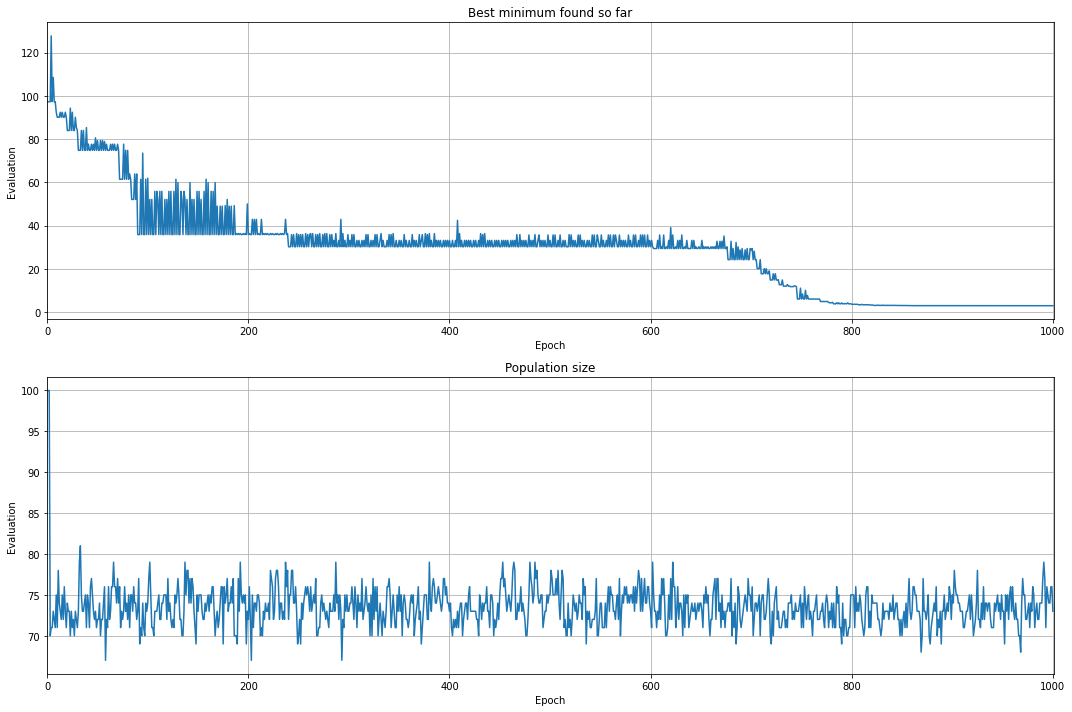

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title("Best minimum found so far")
plt.xlabel("Epoch")
plt.ylabel("Evaluation")
plt.plot(np.arange(1, len(best_scores) + 1), best_scores)
plt.xlim(0, len(best_scores) + 1)
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Population size")
plt.xlabel("Epoch")
plt.ylabel("Evaluation")
plt.plot(np.arange(1, len(pop_size) + 1), pop_size)
plt.xlim(0, len(pop_size) + 1)
plt.grid()

plt.tight_layout()
plt.show()

# Heavy load testing

### CPU

In [ ]:
# Warm-up just to trigger function tracing
solution, energy, best_scores, pop_size = emas_rastrigin(k=2000, epochs=10, n=10000)

start_time = timeit.default_timer()

with tf.device('cpu:0'):
    _, _, best_scores, _ = emas_rastrigin(k=2000, epochs=2500, n=10000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 396.0635s


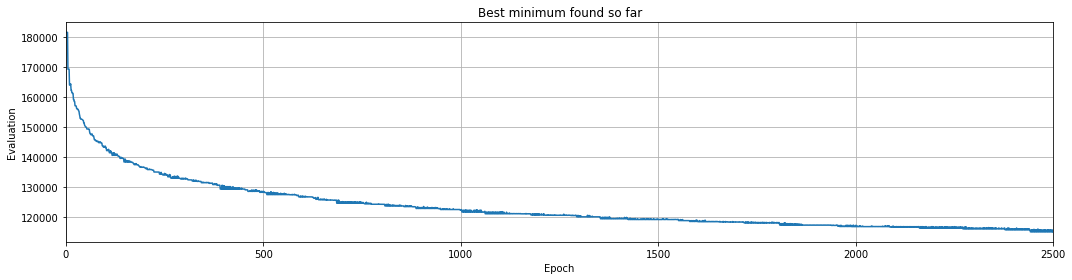

In [ ]:
plt.figure(figsize=(15, 4))

plt.title("Best minimum found so far")
plt.xlabel("Epoch")
plt.ylabel("Evaluation")
plt.plot(np.arange(1, len(best_scores) + 1), best_scores)
plt.xlim(0, len(best_scores) + 1)
plt.grid()

plt.tight_layout()
plt.show()

### GPU (Standard)

In [ ]:
# Warm-up just to trigger function tracing
solution, energy, best_scores, pop_size = emas_rastrigin(k=2000, epochs=10, n=10000)

start_time = timeit.default_timer()

with tf.device('gpu:0'):
    _, _, best_scores, _ = emas_rastrigin(k=2000, epochs=2500, n=10000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 15.5300s


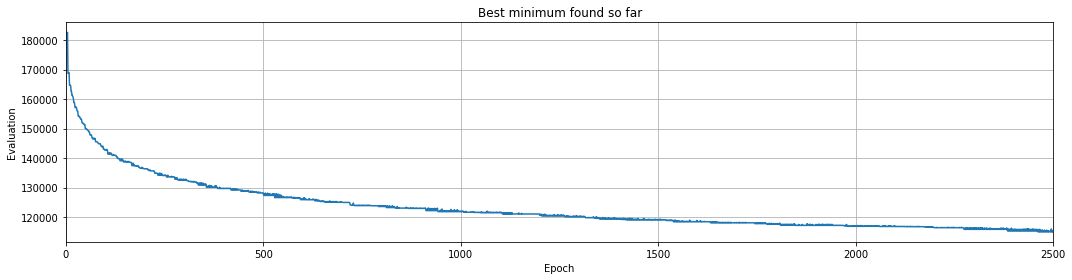

In [ ]:
plt.figure(figsize=(15, 4))

plt.title("Best minimum found so far")
plt.xlabel("Epoch")
plt.ylabel("Evaluation")
plt.plot(np.arange(1, len(best_scores) + 1), best_scores)
plt.xlim(0, len(best_scores) + 1)
plt.grid()

plt.tight_layout()
plt.show()

### GPU (Premium)

In [ ]:
# Warm-up just to trigger function tracing
solution, energy, best_scores, pop_size = emas_rastrigin(k=2000, epochs=10, n=10000)

start_time = timeit.default_timer()

with tf.device('gpu:0'):
    _, _, best_scores, _ = emas_rastrigin(k=2000, epochs=2500, n=10000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 4.3887s


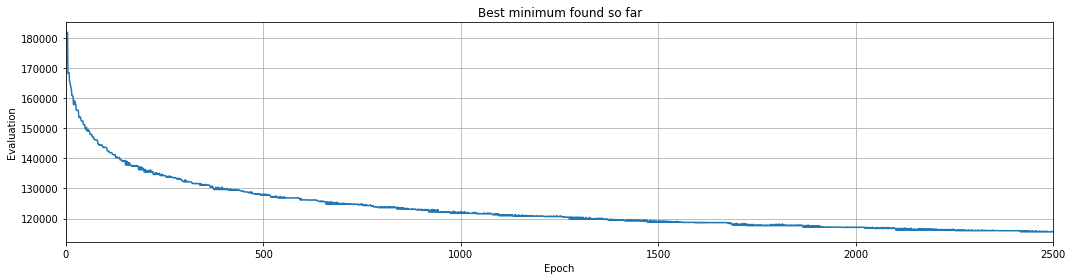

In [ ]:
plt.figure(figsize=(15, 4))

plt.title("Best minimum found so far")
plt.xlabel("Epoch")
plt.ylabel("Evaluation")
plt.plot(np.arange(1, len(best_scores) + 1), best_scores)
plt.xlim(0, len(best_scores) + 1)
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Warm-up just to trigger function tracing
solution, energy, best_scores, pop_size = emas_rastrigin(k=2000, epochs=10, n=10000)

start_time = timeit.default_timer()

with tf.device('gpu:0'):
    _, _, best_scores, _ = emas_rastrigin(k=2000, epochs=50000, n=10000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 88.4901s


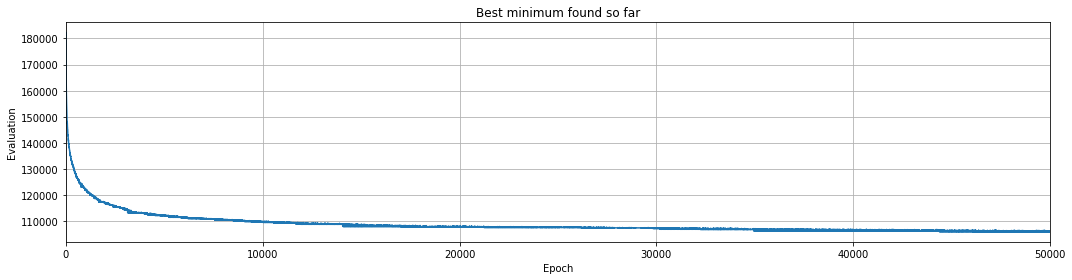

In [ ]:
plt.figure(figsize=(15, 4))

plt.title("Best minimum found so far")
plt.xlabel("Epoch")
plt.ylabel("Evaluation")
plt.plot(np.arange(1, len(best_scores) + 1), best_scores)
plt.xlim(0, len(best_scores) + 1)
plt.grid()

plt.tight_layout()
plt.show()

### TPU

Apparently cannot run if the code is not XLA-compilable. Good to know. Error is the as when trying to trigger XLA by hand (jit_compile=True).

In [ ]:
# Warm-up just to trigger function tracing
solution, energy, best_scores, pop_size = emas_rastrigin(k=2000, epochs=10, n=10000)

start_time = timeit.default_timer()

with tf.device('tpu:0'):
    _, _, best_scores, _ = emas_rastrigin(k=2000, epochs=2500, n=10000)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

InvalidArgumentError: ignored